In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
from data.get_data import get_tubingen_pairs_dataset, get_synthetic_dataset, get_simulated_pairs_dataset, get_multi_pairs_dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [3]:
x, y, weight, target = get_multi_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/multi_pairs/files'
)

In [4]:
tf.config.list_physical_devices('GPU')

2022-07-27 19:24:16.356597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 19:24:16.386249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 19:24:16.386462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
wrong = [0,
 6,
 21,
 30,
 33,
 36,
 54,
 65,
 76,
 89,
 91,
 92,
 100,
 103,
 114,
 116,
 119,
 127,
 133,
 134,
 139,
 144,
 147,
 148,
 150,
 156,
 157,
 161,
 184,
 185,
 191,
 201,
 208,
 211,
 213,
 219,
 228,
 233,
 263,
 264,
 266,
 267,
 281,
 284]

Run number: 0


ELBO 1676.633340212867:   5%|▍         | 999/20000 [03:27<1:05:06,  4.86it/s] 

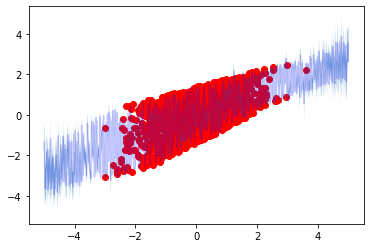

ELBO 1643.8154218094369:  10%|▉         | 1999/20000 [06:54<1:02:02,  4.84it/s]

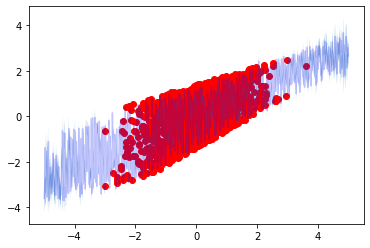

ELBO 1633.6493167712683:  15%|█▍        | 2999/20000 [10:21<58:50,  4.81it/s]  

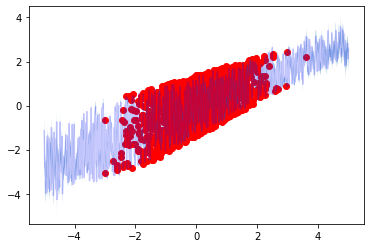

ELBO 1627.5634152499306:  20%|█▉        | 3999/20000 [13:48<54:33,  4.89it/s]  

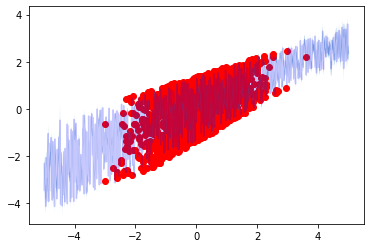

ELBO 1627.0504462938316:  21%|██        | 4154/20000 [14:20<54:42,  4.83it/s]  


KeyboardInterrupt: 

In [14]:
from gpflow.base import Parameter
from gpflow.utilities import positive
from sklearn.preprocessing import StandardScaler
import time
# tf.config.run_functions_eagerly(True)
from tqdm import trange


for i in wrong:
    print(f"Run number: {i}")
    if target[i] > 0:
        input = x[i]
        output = y[i]
    else:
        input = y[i]
        output = x[i]

    # input = np.linspace(1, 100, 100)[:, None]
    # output = input ** 2 + np.random.randn(100)[:, None]

    # print("Data created")

    input = StandardScaler().fit_transform(input).astype(np.float64)
    output = StandardScaler().fit_transform(output).astype(np.float64) 

    kernel_variance = 1.0
    # Likelihood variance
    kappa = np.random.uniform(
        low=10.0, high=100, size=[1]
    )
    # Kernel lengthscale
    lamda = np.random.uniform(
        low=1.0, high=100, size=[1]
    )

    latent_dim = 1
    num_inducing = 200

    kernel_lengthscale = 1. / lamda
    likelihood_variance = Parameter( 1. / (kappa ** 2), transform=positive(lower=1e-6))

    kernel_lengthscale = 0.05
    likelihood_variance = 0.001

    # print(f"Initial hyper: lengthscale - {kernel_lengthscale}, variance - {likelihood_variance.numpy()}")


    # Put in new values of hyperparams
    # X_mean_init = output - reg_gp_model.predict_y(input)[0]
    sq_exp = gpflow.kernels.SquaredExponential(
        lengthscales=[kernel_lengthscale] + [kernel_lengthscale / 3]
    )
    sq_exp.variance.assign(1)
    linear_kernel = gpflow.kernels.Linear(variance=1 + 1e-20)


    # sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[kernel_lengthscale[0], kernel_lengthscale[1]])

    # linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)
    # poly_kernel = gpflow.kernels.Polynomial(degree=2, variance=kernel_variance)

    # sq_exp.variance.assign(kernel_variance)

    # quadratic_kernel = gpflow.kernels.Product([linear_kernel, linear_kernel_2])

    # kernel = poly_kernel
    kernel = gpflow.kernels.Sum([linear_kernel, sq_exp])
    # kernel_2 = gpflow.kernels.Sum([linear_kernel_2, sq_exp_2])
    # kernel = gpflow.kernels.SeparateIndependent(
    #     [
    #         kernel,  # This is k1, the kernel of f1
    #         kernel_2  # this is k2, the kernel of f2
    #     ]
    # )


    Z = gpflow.inducing_variables.InducingPoints(
        np.concatenate(
            [
                np.linspace(input.min(), input.max(), num_inducing).reshape(-1, 1),
                np.random.randn(num_inducing, 1),
            ],
            axis=1
        )
    )
    inducing_variable = Z
    # Z_2 = gpflow.inducing_variables.InducingPoints(
    #     np.concatenate(
    #         [
    #             np.linspace(input.min(), input.max(), num_inducing).reshape(-1, 1),
    #             np.random.randn(num_inducing, 1),
    #         ],
    #         axis=1
    #     )
    # )
    # inducing_variable = gpflow.inducing_variables.SeparateIndependentInducingVariables(
    #     [
    #         Z,  # This is U1 = f1(Z1)
    #         Z_2,  # This is U2 = f2(Z2)
    #     ]
    # )
    X_mean_init = 0.01 * tf.cast(output, default_float())
    X_var_init = tf.cast(
        np.random.uniform(0, 0.1, (input.shape[0], latent_dim)), default_float()
    )

    m = PartObsBayesianGPLVM(
        data=output,
        in_data=input,
        kernel=kernel,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        inducing_variable=inducing_variable,
        jitter=1e-6
    )
    m.likelihood.variance = Parameter(
        likelihood_variance + 1e-20, transform=positive(lower=1e-6)
    )

    loss_fn = m.training_loss_closure()

    adam_vars = m.trainable_variables
    adam_opt = tf.optimizers.Adam(0.1)
    @tf.function
    def optimisation_step():
        adam_opt.minimize(loss_fn, adam_vars)

    epochs = int(20e3)
    log_freq = 100
    with trange(1, epochs + 1) as pbar:
        losses = []
        for epoch in pbar:
            optimisation_step()
            if epoch % log_freq == 0:
                pbar.set_description(f"ELBO {- m.elbo()}")
            if epoch % 1000 == 0:
                obs_new = np.linspace(-5, 5, 1000)[:, None]

                Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
                Xnew = tf.cast(Xnew, dtype=default_float())
                Xnew = tf.concat(
                    [obs_new, Xnew], axis=1
                )
                pred_f_mean, pred_f_var = m.predict_y(
                    Xnew=Xnew,
                )
                plt.scatter(input[:, 0], output[:, 0], c='r')
                plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
                # plt.scatter(inducing_in, np.zeros(100) )
                plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
                plt.show()
                plt.close()
            losses.append(- m.elbo())
            if epoch > 101:
                losses.pop(0)
            if epoch > 1000 and np.abs(np.mean(losses[0:50]) - np.mean(losses[50:100])) < np.std(losses):
                print("BREAKING!")
                break                

    # tf.print("ELBO:", - m.elbo())


    # Train everything
    # tf.print("Training everything")
    # gpflow.utilities.set_trainable(m.kernel, True)
    # gpflow.utilities.set_trainable(m.likelihood, False)
    # gpflow.utilities.set_trainable(m.X_data_mean , True)
    # gpflow.utilities.set_trainable(m.X_data_var, True)
    # gpflow.utilities.set_trainable(m.inducing_variable, True)
    # opt = gpflow.optimizers.Scipy()
    # opt_logs = opt.minimize(
    #     m.training_loss,
    #     m.trainable_variables,
    #     method="L-BFGS-B",
    #     options=dict(maxiter=200000),
    # )
    # tf.print("Training everything")
    # gpflow.utilities.set_trainable(m.kernel, True)
    # gpflow.utilities.set_trainable(m.likelihood, True)
    # gpflow.utilities.set_trainable(m.X_data_mean , True)
    # gpflow.utilities.set_trainable(m.X_data_var, True)
    # gpflow.utilities.set_trainable(m.inducing_variable, True)
    # opt = gpflow.optimizers.Scipy()
    # opt_logs = opt.minimize(
    #     m.training_loss,
    #     m.trainable_variables,
    #     method="L-BFGS-B",
    #     options=dict(maxiter=200000),
    # )
    tf.print("ELBO:", - m.elbo())

    tf.print(f"target: {target[i]}")
    loss = - m.elbo()

    obs_new = np.linspace(-5, 5, 1000)[:, None]

    Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
    Xnew = tf.cast(Xnew, dtype=default_float())
    Xnew = tf.concat(
        [obs_new, Xnew], axis=1
    )
    pred_f_mean, pred_f_var = m.predict_y(
        Xnew=Xnew,
    )
    plt.scatter(input[:, 0], output[:, 0], c='r')
    plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
    # plt.scatter(inducing_in, np.zeros(100) )
    plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
    plt.show()
    plt.close()
    import pdb; pdb.set_trace()


In [7]:
import gpflux
import numpy as np
import tensorflow_probability as tfp
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm


def train_gpflux(
    x,
    y,
    num_inducing,
):
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    w_dim = 1
    prior_means = np.zeros(w_dim)
    prior_std = np.ones(w_dim)
    encoder = gpflux.encoders.DirectlyParameterizedNormalDiag(x.shape[0], w_dim)
    prior = tfp.distributions.MultivariateNormalDiag(prior_means, prior_std)
    lv = gpflux.layers.LatentVariableLayer(prior, encoder)

    linear_kernel = gpflow.kernels.Linear(variance=1.)
    sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[.05, .2], variance=1.)
    kernel = gpflow.kernels.Sum([linear_kernel, sq_exp])

    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.concatenate(
            [
                np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1),
                np.random.randn(num_inducing, 1),
            ],
            axis=1
        )
    )
    gp_layer = gpflux.layers.GPLayer(
        kernel,
        inducing_variable,
        num_data=x.shape[0],
        num_latent_gps=1,
        mean_function=gpflow.mean_functions.Zero(),
    )


    kernel = gpflow.kernels.SquaredExponential()
    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.random.randn(num_inducing, 1),
    )
    gp_layer2 = gpflux.layers.GPLayer(
        kernel,
        inducing_variable,
        num_data=x.shape[0],
        num_latent_gps=1,
        mean_function=gpflow.mean_functions.Identity(),
    )
    gp_layer2.q_sqrt.assign(gp_layer.q_sqrt * 1e-5);

    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))
    gpflow.set_trainable(likelihood_layer, True)
    dgp = gpflux.models.DeepGP([lv, gp_layer, gp_layer2], likelihood_layer)
    tf.print( - dgp.elbo((x, y)))
    model = dgp.as_training_model()
    model.compile(tf.optimizers.Adam(0.005))

    history = model.fit({"inputs": tf.cast(x, tf.float64), "targets": tf.cast(y, tf.float64)}, epochs=int(20e3), verbose=0, batch_size=x.shape[0], shuffle=False)

    loss = - dgp.elbo((x, y))
 
    # Plot the fit to see if everything is ok
    obs_new = np.linspace(-5, 5, 1000)[:, None]

    def predict_y_samples(prediction_model, Xs):
        out = prediction_model(Xs)
        s = out.y_mean + out.y_var ** .5 * tf.random.normal(tf.shape(out.y_mean), dtype=out.y_mean.dtype)
        return out.y_mean[:, 0], out.y_var[:, 0]

    pred_y_mean, pred_y_var = predict_y_samples(dgp.as_prediction_model(), obs_new)
    textstr = 'elbo=%.2f\n'%(
        loss
    )
    plt.text(-17, 0, textstr, fontsize=8)
    plt.scatter(x, y, c='r')
    plt.plot(obs_new, pred_y_mean, c='b', alpha=0.6)
    plt.fill_between(obs_new[:, 0], (pred_y_mean + 2 * np.sqrt(pred_y_var)), (pred_y_mean - 2 * np.sqrt(pred_y_var)), alpha=0.5)
    plt.subplots_adjust(left=0.25)
    plt.show()
    plt.close()

In [8]:
for i in wrong:
    print(f"Run: {i}")
    print("X -> Y")
    train_gpflux(x[i], y[i], 200)
    print("Y -> X")
    train_gpflux(y[i], x[i], 200)

Run: 76
X -> Y


/tmp/ipykernel_1531910/1094131124.py:4: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  train_gpflux(x[i], y[i], 200)
/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


233837.27449858334
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


/vol/bitbucket/ad6013/envs/gp-causal-env/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


KeyboardInterrupt: 